In this notebook we try to use the flow network for simulations

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import get_data_dir_path

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
# sys.path.insert(0, "../")

## Load trained models

In [ ]:
data_dir = get_data_dir_path()

tf.get_logger().setLevel("ERROR")
latent_dim = 16
num_nf_layers = 6
kl_weight = 1

model_path = os.path.join(data_dir, "LSST0.01")

flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers)

flow_net.load_flow_weights(weights_path=os.path.join(model_path, "flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "vae/val_loss"))

flow_net.vae_model.trainable = False
flow_net.flow_model.trainable = False

print(flow_net.vae_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 45, 45, 6)]       0         
                                                                 
 encoder (Functional)        (None, 152)               6696216   
                                                                 
 latent_space (MultivariateN  ((None, 16),             0         
 ormalTriL)                   (None, 16))                        
                                                                 
 decoder (Functional)        (None, 45, 45, 6)         3657446   
                                                                 
Total params: 10,353,662
Trainable params: 0
Non-trainable params: 10,353,662
_________________________________________________________________
None


### sample Latent space

sample form the base distribution, apply the bijector and then feed it to the decoder. 
Ideally, it should generate the image of a galaxy

In [ ]:
zdist = tfd.Independent(
    tfd.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1
)
base_sample = zdist.sample(100000)

In [ ]:
sampled_data = flow_net.td.sample(100000).numpy()
data = []
for i in range(latent_dim):
    data.append(sampled_data[:, i])

Text(0, 0.5, 'distribution')

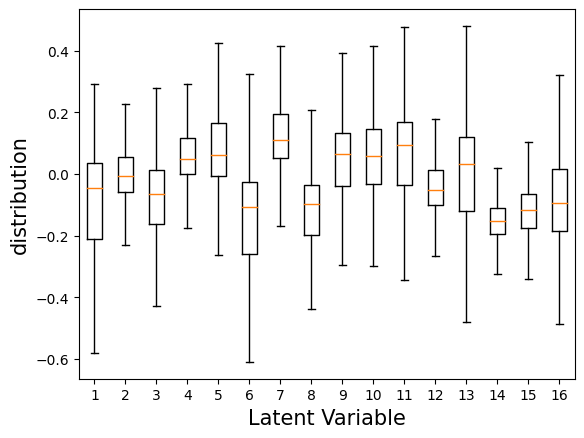

In [ ]:
plt.boxplot(data, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

# First simulate from the latent space prior

In [ ]:
prior_simulation = flow_net.decoder(zdist.sample(10, seed=17)).numpy()

In [ ]:
np.shape(prior_simulation)

(10, 45, 45, 6)

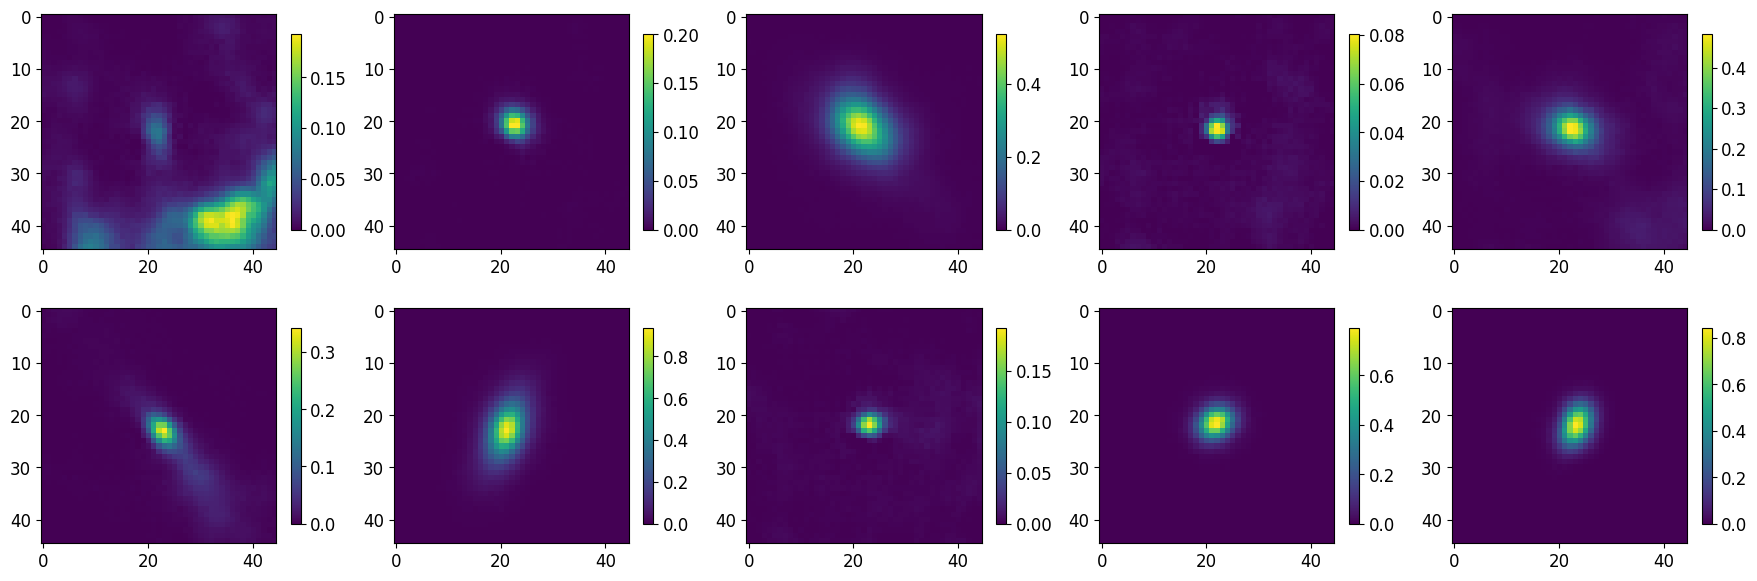

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(22, 7))

for plot_row in range(2):
    for plot_col in range(5):
        im = axs[plot_row][plot_col].imshow(
            prior_simulation[plot_row * 5 + plot_col, :, :, 2]
        )
        cbar = fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        cbar.ax.tick_params(labelsize=12)
        axs[plot_row][plot_col].tick_params(axis="both", which="major", labelsize=12)
        # axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))

plt.savefig("results/prior_simulations")
plt.savefig("results/prior_simulations.pdf", bbox_inches="tight")

# Now try the Normalizing Flow

In [ ]:
simulation = flow_net.decoder(flow_net.td.sample(10, seed=11)).numpy()

In [ ]:
np.shape(simulation)

(10, 45, 45, 6)

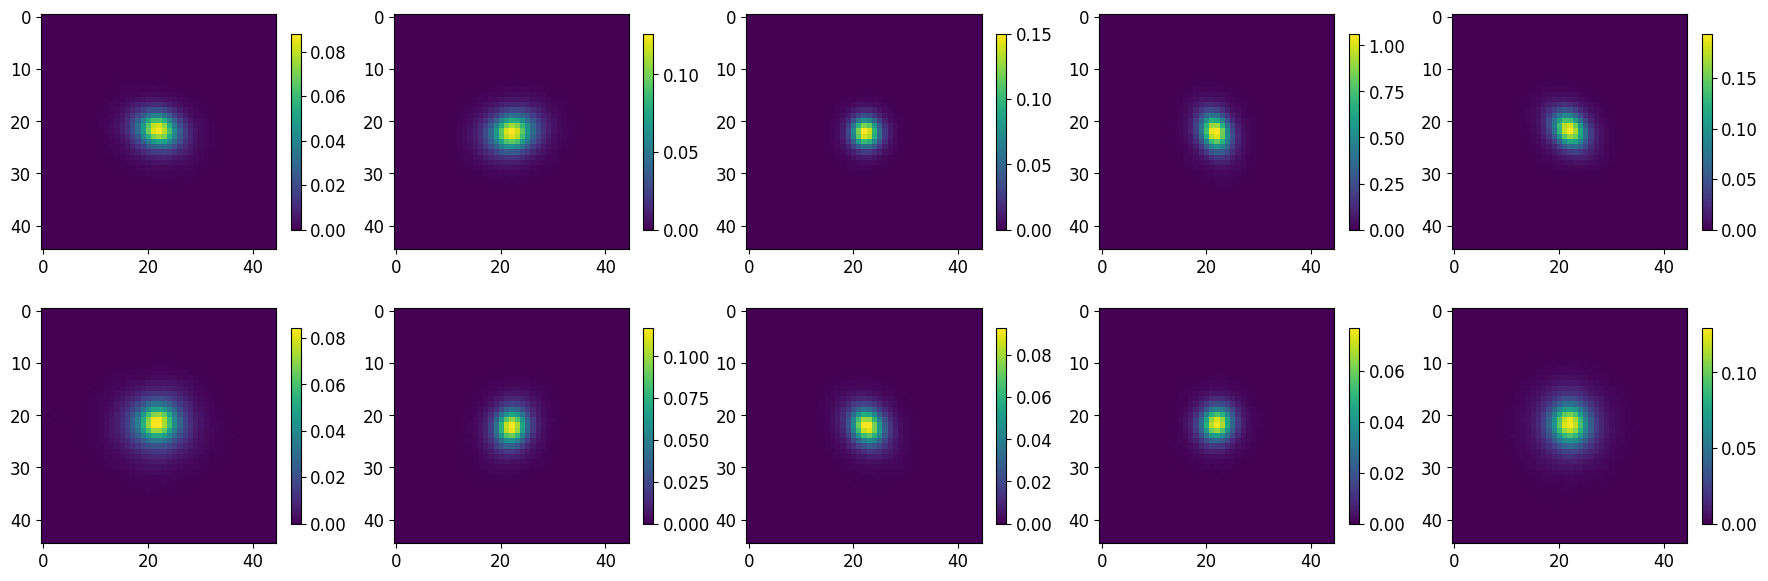

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(22, 7))

for plot_row in range(2):
    for plot_col in range(5):

        im = axs[plot_row][plot_col].imshow(
            simulation[plot_row * 5 + plot_col, :, :, 2]
        )
        cbar = fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        cbar.ax.tick_params(labelsize=12)
        axs[plot_row][plot_col].tick_params(axis="both", which="major", labelsize=12)
        # axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))

plt.savefig("results/nf_simulations")
plt.savefig("results/nf_simulations.pdf", bbox_inches="tight")